In [1]:
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import glob
import os

In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)


def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

['data/names/Irish.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Portuguese.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/French.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Japanese.txt', 'data/names/Dutch.txt', 'data/names/Chinese.txt', 'data/names/Arabic.txt', 'data/names/Spanish.txt']
Slusarski
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [3]:
n_hidden = 128
n_epochs = 2000000
print_every = 10000
plot_every = 2000
learning_rate = 0.002 # If you set this too high, it might explode. If too low, it might not learn

def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [4]:
class MyLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(MyLSTM, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=False) #lstm
        self.linear = nn.Linear(self.hidden_size, self.num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        output,_ = self.lstm(x) # (seq_length, 1, hidden_size)
        #print(output)
        #print(output.size())
        output = self.linear(output[-1])
        #print(output.size())
        output = self.softmax(output)
        #print(output.size())
        return output
        
        
        

In [5]:
lstm = MyLSTM(num_classes = n_categories,
              input_size=n_letters,
             hidden_size = n_hidden,
             num_layers =1,
             seq_length = None)
optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()
lstm = lstm.cuda()

In [6]:
def train(category_tensor, line_tensor):
    optimizer.zero_grad()

    output = lstm(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [7]:
# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [8]:
start = time.time()
for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = randomTrainingPair()
    output, loss = train(category_tensor.cuda(), line_tensor.cuda())
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        #print(current_loss)
        current_loss = 0
    

10000 0% (0m 8s) 2.8347 Sai / Czech ✗ (Vietnamese)
20000 1% (0m 17s) 2.8384 Alunni / French ✗ (Italian)
30000 1% (0m 26s) 2.9531 Jacques / Greek ✗ (French)
40000 2% (0m 34s) 2.7434 Zambrano / Italian ✓
50000 2% (0m 43s) 2.7621 Giese / Greek ✗ (German)
60000 3% (0m 52s) 2.7692 Armistead / Greek ✗ (French)
70000 3% (1m 1s) 1.9618 Gropyanov / Russian ✓
80000 4% (1m 10s) 2.4563 Winfer / German ✗ (English)
90000 4% (1m 19s) 2.6953 Whitworth / Russian ✗ (English)
100000 5% (1m 31s) 1.2808 Gomulka / Polish ✓
110000 5% (1m 43s) 1.2763 Vu / Korean ✗ (Vietnamese)
120000 6% (1m 55s) 1.5432 Hofwegen / Dutch ✓
130000 6% (2m 7s) 2.0721 Reyer / German ✗ (French)
140000 7% (2m 19s) 0.3441 Avhimovitch / Russian ✓
150000 7% (2m 30s) 1.0132 Bouchard / French ✓
160000 8% (2m 42s) 1.3620 Araullo / Italian ✗ (Portuguese)
170000 8% (2m 54s) 0.9316 Fortunato / Italian ✓
180000 9% (3m 6s) 0.4604 Kaminski / Polish ✓
190000 9% (3m 18s) 1.5051 Issa / Arabic ✓
200000 10% (3m 30s) 2.1145 Jasso / Japanese ✗ (Spanish

1690000 84% (33m 4s) 1.6608 Martin / Scottish ✗ (French)
1700000 85% (33m 16s) 0.0010 Niemczyk / Polish ✓
1710000 85% (33m 28s) 0.0067 Szwarc / Polish ✓
1720000 86% (33m 40s) 0.0276 Berti / Italian ✓
1730000 86% (33m 52s) 0.8049 Froltsov / Czech ✗ (Russian)
1740000 87% (34m 4s) 0.0007 Sneijders / Dutch ✓
1750000 87% (34m 16s) 0.0001 Katayanagi / Japanese ✓
1760000 88% (34m 27s) 0.0459 Banderas / Spanish ✓
1770000 88% (34m 39s) 0.0473 Tse / Chinese ✓
1780000 89% (34m 51s) 2.6544 Kan / Chinese ✗ (Dutch)
1790000 89% (35m 3s) 0.0072 Feng / Chinese ✓
1800000 90% (35m 15s) 0.1491 Samson / French ✓
1810000 90% (35m 27s) 0.0252 Vuu / Vietnamese ✓
1820000 91% (35m 39s) 0.0171 Macdonald / Scottish ✓
1830000 91% (35m 50s) 0.0019 Brzezicki / Polish ✓
1840000 92% (36m 2s) 0.0157 Biggs / English ✓
1850000 92% (36m 14s) 0.0000 Kaminaga / Japanese ✓
1860000 93% (36m 26s) 0.0007 Sawamura / Japanese ✓
1870000 93% (36m 37s) 0.0000 Yakhlakov / Russian ✓
1880000 94% (36m 49s) 0.0008 Naifeh / Arabic ✓
18900

In [9]:
torch.save(lstm, './checkpoints/char-lstm-classification.pt')

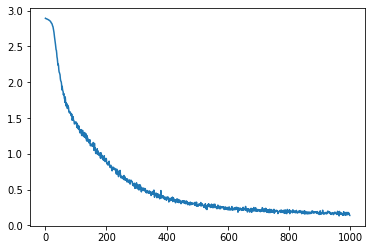

In [10]:
plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_940803/2877789620.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_940803/2877789620.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


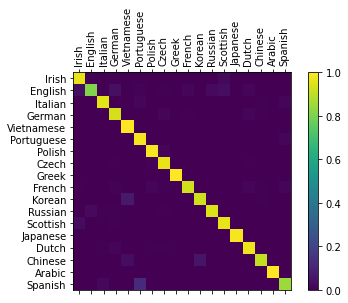

In [11]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    output = lstm(line_tensor.cuda()).cpu()
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [12]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.01) Russian
(-4.93) English
(-8.46) Czech

> Jackson
(-0.05) Scottish
(-3.05) English
(-7.59) Russian

> Satoshi
(-0.00) Japanese
(-9.53) Polish
(-11.83) Czech


In [13]:
from sklearn.metrics import roc_auc_score
from torch.nn.functional import one_hot

for category, input_lines in category_lines.items():
    category_tensor = torch.LongTensor([all_categories.index(category)])
    categroy_one_hot_tensor = one_hot(category_tensor, num_classes=n_categories)
    print(category, len(input_lines))


Irish 232
English 3668
Italian 709
German 724
Vietnamese 73
Portuguese 74
Polish 139
Czech 519
Greek 203
French 277
Korean 94
Russian 9408
Scottish 100
Japanese 991
Dutch 297
Chinese 268
Arabic 2000
Spanish 298


In [14]:

y_gts = []
y_preds = []
for category, input_lines in category_lines.items():
    category_tensor = torch.LongTensor([all_categories.index(category)])
    categroy_one_hot_tensor = one_hot(category_tensor, num_classes=n_categories)
    for input_line in input_lines:
        #print(input_line)
        output = evaluate(lineToTensor(input_line))
        y_gts.append(categroy_one_hot_tensor.squeeze().detach().numpy())
        y_preds.append(torch.exp(output).squeeze().detach().numpy())


In [15]:
roc_auc_score(y_gts, y_preds)

0.9976671929148134